This file is intended to run within Mask_RCNN_stuff
 folder in Colab

# Setup Code


### Add a short cut of this shared folder to your own Google Drive.

1) The link to the shared folder is:
https://drive.google.com/drive/folders/1q23QGS28uWzC22kCXXYILY4DEgrw3AjD?usp=sharing

2) Go to "Shared with Me" and find this folder. Right Click and select "Add shortcut to Drive"

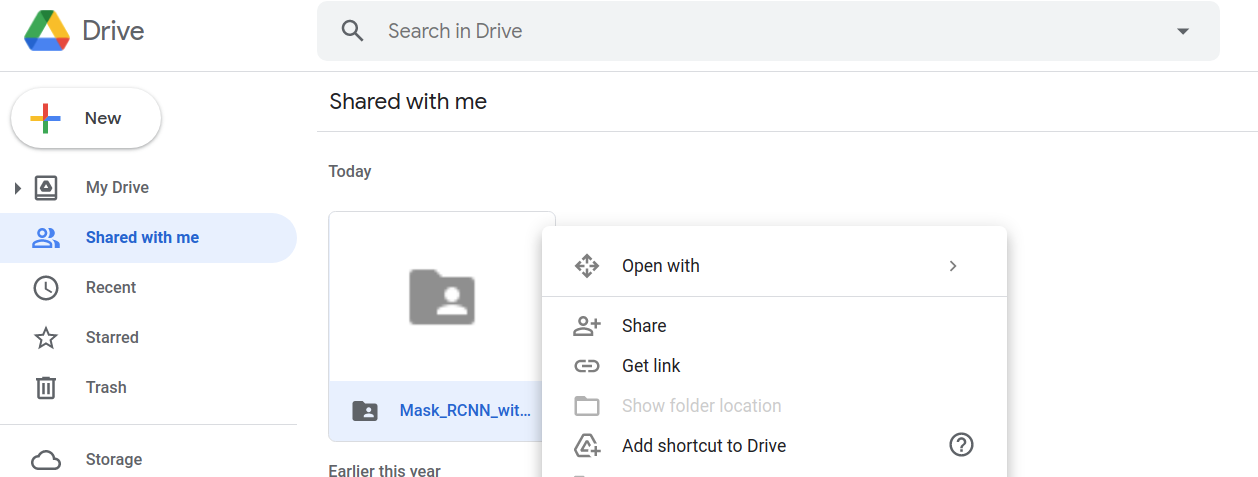

3) Click "Add" to add a shortcut to MyDrive

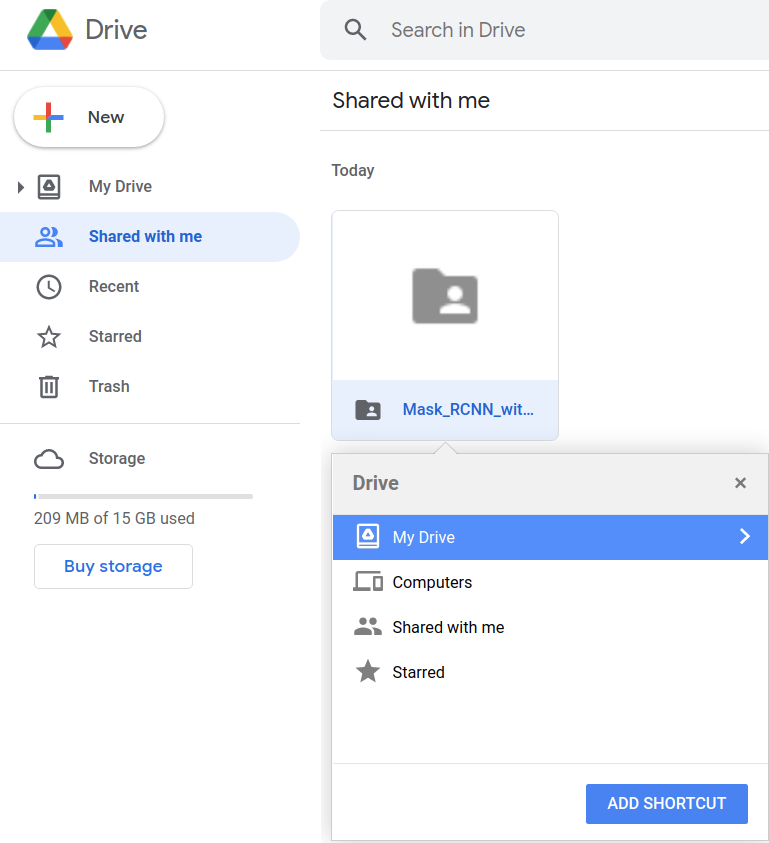

**Now you are able to read and load any data from this shared folder. This shared folder is read-only. However, if you want to write or store any intermidate file, you can do one of the follwing:**

**- Please create a new folder outside and change the path accordinly to store your output. (Recommended)**

**- Download the folder and re-upload to your google drive**

### Mount Google Drive and Define path to "Mask_RCNN_with_Optical

**Note**: Be sure to choose runtime as "GPU" in Colab. You can do that under "Runtime"->"Change runtime type"->Then Select GPU

In [ ]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

# By finishing the setup, "Mask_RCNN_with_Optical_Flow" folder is under "drive/MyDrive" folder
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Mask_RCNN_with_Optical_Flow'
ROOT_DIR = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(ROOT_DIR)) 
# You should see a list of files starts with 'mask_rcnn_coco.h5'. Otherwise, change the Path correctly.

import sys
sys.path.append(ROOT_DIR)

# Install packages & Download weights

In [ ]:
# the following version can run the thing, even though not the best ones
!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install scipy==1.2.1
!pip install tensorflow-gpu==1.13.1

# Mask RCNN
Mask RCNN is used to get bounding boxes and masks for each vehicle and pedestrain in each frame.


## Setup Mask RCNN
A quick intro to using the pre-trained model to detect and segment objects.

In [ ]:
import sys
import random
import math
import numpy as np
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt
import cv2

import coco
import utils
import model as modellib
import visualize

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights file
# This file should be in "Mask_RCNN_with_Optical_Flow" folder
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")


'''
Configurations
We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the CocoConfig class in coco.py.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the CocoConfig class and override the attributes you need to change.
'''
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.print()


'''
Create Model and Load Trained Weights
'''

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)


'''
Class Names
The model classifies objects and returns class IDs, which are integer 
value that identify each class. Some datasets assign integer values to 
their classes and some don't. For example, in the MS-COCO dataset, the
 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential,
  but not always. The COCO dataset, for example, has classes associated 
  with class IDs 70 and 72, but not 71.
'''
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection & Store in pickle

In [ ]:
# the name of the folder under ROOT_DIR that contains frames of the video. 
# We provide three folders of video frames from MOT16. "MOT16-09", "MOT16-11", "MOT16-14"
VIDEO_NAME = "MOT16-09" 

# Directory of images(frames) to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, VIDEO_NAME)

# Make Sure a folder with this name is created under ROOT_DIR
# This is used to store results of Mask RCNN
MASK_RCNN_PICKLES_PATH = os.path.join(ROOT_DIR, "Mask RCNN Pickles") 

PICKLE_PREFIX = os.path.join(MASK_RCNN_PICKLES_PATH, VIDEO_NAME) 

Run Mask RCNN for each frame. Save the results in 50-frame long chunks.

In [ ]:
import pickle, os
import imageio

file_names = os.listdir(IMAGE_DIR)
file_names.sort()

# start index of each chunk of pickle
start_idx = 0
# Run detection
results = []
for i, file_name in enumerate(file_names):
    print("work on frame", i)
    image = imageio.imread(os.path.join(IMAGE_DIR, file_name))
    result = model.detect([image], verbose=0)
    r = result[0] # there is only one image

    # only keep person, cicycle, car, motorcycle, bus, and truck
    idx_to_keep = np.concatenate([np.where(r['class_ids'] == 1)[0], \
                          np.where(r['class_ids'] == 2)[0], \
                          np.where(r['class_ids'] == 3)[0], \
                          np.where(r['class_ids'] == 4)[0], \
                          np.where(r['class_ids'] == 6)[0], \
                          np.where(r['class_ids'] == 8)[0]])

    r['rois'] = r['rois'][idx_to_keep]
    r['masks'] = r['masks'][:,:, idx_to_keep]
    r['class_ids'] = r['class_ids'][idx_to_keep]
    r['scores'] = r['scores'][idx_to_keep]
    results.append(r)
    # To avoid crashing RAM in colab, we save segments of video by every 50 frames
    if (i - 49) % 50 == 0 or i == (len(file_names) - 1): # stores after frame 49 99 149 or the last frame
      print("saving results @ " + format(start_idx, '06') + " to " + format(i, '06'))
      # dump with pickle
      pickle.dump(results, open(PICKLE_PREFIX + '_Frame_' + format(start_idx, '06') + '_to_' + format(i, '06') + '.pkl', 'wb'))
      results = [] # clear up results list
      start_idx = i + 1 # update start index for the next pickle file


# Dense Optical Flow


## Optical Flow 
1. Load Mask RCNN results from pickles & load video frames from IMAGE_DIR 
2. Run Dense Optical Flow algorithm on original video to get pixel-level flows between each two frames.
3. Then use the masks genereated by Mask RCNN to extract flow infomation for each detected object.
4. Average the flow data for each object and save as its "flow" in results


### Load Mask RCNN + Run dense optical flow + Averaging

In [ ]:
VIDEO_NAME = "MOT16-09" 
# the name of the folder under ROOT_DIR that contains frames of the video
IMAGE_DIR = os.path.join(ROOT_DIR, VIDEO_NAME)

# Make Sure a folder with this name is created.
MASK_RCNN_PICKLES_PATH = os.path.join(ROOT_DIR, "Mask RCNN Pickles") 

PICKLE_PREFIX = os.path.join(MASK_RCNN_PICKLES_PATH, VIDEO_NAME) 

# Make sure a folder with the name is created under ROOT_DIR.
# This folder is used to store results of using masks on Optical Flow 
OPTICAL_FLOW_JOSNS_PATH = os.path.join(ROOT_DIR, "Optical Flow Jsons")

In [ ]:
import pickle, os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Flags
viz = False # set it True to visualize the result. Note: this may crash the RAM, try it on a small batch of images <50
first_batch_first_frame = True

all_mask_rcnn_pickles = os.listdir(MASK_RCNN_PICKLES_PATH)

image_file_names = os.listdir(IMAGE_DIR)
image_file_names.sort()

# Get all to-be-processed picke_file_names of currnet VIDEO_NAME
print("Getting all to-be-processed picke filenames from " + VIDEO_NAME + ":")
pickle_file_names = []
for i, file in enumerate(all_mask_rcnn_pickles):
    if file.startswith(VIDEO_NAME + '_Frame_'):
      pickle_file_names.append(file)
      print(" " + str(i+1) + ". " + file)


# a list to store optical flow results
flow_results = [] # a list of frame dictionaries, 
           # each dictionary has four keys "bb", "flows", "scores", "class_ids"
           # their values are a list of data for each detected object

# Process the first frame
frame1 = cv2.imread(os.path.join(IMAGE_DIR, image_file_names[0]))
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY) #convert to grayscale

if viz:
  hsv = np.zeros_like(frame1)
  hsv[...,1] = 255

for i, file in enumerate(pickle_file_names):
  print("\nLoading " + str(i) + ". " + os.path.join(MASK_RCNN_PICKLES_PATH, file))
  mask_rcnn_load_res = pickle.load(open(os.path.join(MASK_RCNN_PICKLES_PATH, file), 'rb'))
  
  for curr_pickle_idx in range(len(mask_rcnn_load_res)):
    if (first_batch_first_frame): # the very first image is already processed
      first_batch_first_frame = False
      continue

    curr_image_idx = i * 50 + curr_pickle_idx 
    # 50 is the fixed size of each mask_rcnn pickle file
    # However, the last segment may be an exception, 

    print("working on image idx #", curr_image_idx, 
          "image_frame_name: ", image_file_names[curr_image_idx])

    # process current frame with previous frame. 
    frame2 = cv2.imread(os.path.join(IMAGE_DIR, image_file_names[curr_image_idx]))
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 25, 3, 5, 1.2, 0) 
    # https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af

    # Update prvs
    prvs = next
    
    ''' 
    Create a New dictionary to store results in current frame
    '''
    res_dict = {}

    if (curr_pickle_idx != 0):
      prev_mask_rcnn_load_res = mask_rcnn_load_res[curr_pickle_idx - 1]
    else:
      #set previous frame's mask rcnn result to be prev_file_last_frame_dict
      prev_mask_rcnn_load_res = prev_file_last_frame_dict 

    # Store scores and class_id
    res_dict['scores'] = prev_mask_rcnn_load_res['scores'].tolist()
    res_dict['class_ids'] = prev_mask_rcnn_load_res['class_ids'].tolist()

    # Calculates bounding boxes' centers and widths & heights in prvs frame
    bb_info = []
    list_of_bb = prev_mask_rcnn_load_res['rois']
    for bb in list_of_bb:
      bb_x = (bb[1] + bb[3]) / 2.0 
      bb_y = (bb[0] + bb[2]) / 2.0 
      bb_info.append([bb_x, bb_y, int(abs(bb[3]-bb[1])), int(abs(bb[2]-bb[0]))])
      # The order: x_center, y_center, width(in x-axis), heights.
      # (0,0)is top left, x-positive is to right, y-positive is to down
    res_dict['bb'] = bb_info

    # Appying masks to get averaged flow from prvs to next frame for each detected object
    flows_info = []
    for obj_idx in range(prev_mask_rcnn_load_res['masks'].shape[2]):
      # print(prev_mask_rcnn_load_res['masks'].shape[2]," many of objects")
      mask = prev_mask_rcnn_load_res['masks'][:,:,obj_idx]
      num_pixels = np.sum(mask)
      
      # use mask to filter out pixel values that doesn't belong to this object
      flow_mask_x = np.where(mask, flow[:,:,0], 0)
      flow_mask_y = np.where(mask, flow[:,:,1], 0)

      # calculate average flows in x and y direction.
      avg_x_vel = np.sum(flow_mask_x) / num_pixels
      avg_y_vel = np.sum(flow_mask_y) / num_pixels
      flows_info.append([avg_x_vel, avg_y_vel])
    res_dict['flows'] = flows_info

    # Push current frame's dictionary into results
    flow_results.append(res_dict)

    # Visualize optical flow with Mask RCNN results in HSV representation 
    if viz :
      mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
      hsv[...,0] = ang*180/np.pi/2
      hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
      bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
      visualize.display_instances(bgr, prev_mask_rcnn_load_res['rois'], \
          prev_mask_rcnn_load_res['masks'], prev_mask_rcnn_load_res['class_ids'], \
                class_names, prev_mask_rcnn_load_res['scores'])  

  # the mask rcnn result of the last frame in a pickle file.
  prev_file_last_frame_dict = mask_rcnn_load_res[-1]

print(flow_results)

### Store optical flow results in a json file

In [ ]:
import json
JSON_DIR = os.path.join(OPTICAL_FLOW_JOSNS_PATH, (VIDEO_NAME +'_optical_flow_res.json'))
with open(JSON_DIR, 'w') as fout:
    json.dump(flow_results, fout)

## Visualize Optical Flow (Optional)
Visualize Mask RCNN + Optical Flow resutls using arrows to represent averaged flow for each detected object. 

### Create a folder on colab to store images

In [ ]:
!mkdir temp_images_folder
%cd temp_images_folder
!pwd

### Visualize optical flow results with corresponding images

In [ ]:
import json
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

VIDEO_NAME = "MOT16-09" # the name of the folder under ROOT_DIR that contains frames of the video
IMAGE_DIR = os.path.join(ROOT_DIR, VIDEO_NAME) # where stores frames of original video
JSON_DIR = os.path.join(ROOT_DIR, "Optical Flow Jsons", \
                        (VIDEO_NAME +'_optical_flow_res.json'))# path to load optical flow results

image_file_names = os.listdir(IMAGE_DIR)
image_file_names.sort()

with open(JSON_DIR, "r") as read_file:
  loaded_flow_results = json.load(read_file)

for i, load_flow_result in enumerate(loaded_flow_results):
  print("work on image # ", i)
  image = cv2.imread(os.path.join(IMAGE_DIR, image_file_names[i]))

  bb_info = load_flow_result['bb']
  flows = load_flow_result['flows']

  for j, bbox_in in enumerate(bb_info):
    center_x = int(bbox_in[0])
    center_y = int(bbox_in[1])
    half_width = bbox_in[2] / 2.0
    half_height = bbox_in[3] / 2.0
    cv2.rectangle(image, (int(center_x - half_width), \
                          int(center_y - half_height)), \
                  (int(center_x + half_width), \
                   int(center_y + half_height)),(100,255,0), 2)
    
    x_flow = flows[j][0]
    y_flow = flows[j][1]

    cv2.arrowedLine(image, (int(center_x), int(center_y)),\
                    (int(center_x + 10*x_flow), int(center_y + 10*y_flow)), \
                    (100,200,255), 5, tipLength = 0.5) 
  
  # cv2_imshow(image)
  cv2.imwrite((VIDEO_NAME + '_' + format(i, '06') +'.jpg'), image)
  cv2.waitKey(0) 

### Combine images into video

In [ ]:
import cv2
import numpy as np

TEMP_IMAGES_DIR = '/content/temp_images_folder' # Change the path to where the previous cell stores frames

image_file_names = os.listdir(TEMP_IMAGES_DIR)
image_file_names = [x for x in image_file_names if x.startswith(VIDEO_NAME)]
image_file_names.sort()


img = cv2.imread(os.path.join(TEMP_IMAGES_DIR,image_file_names[0]))
height,width,layers = img.shape

# Change the path to store video elsewhere
video=cv2.VideoWriter('/content/'+VIDEO_NAME+'_optical_flow_viz_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 4,(width,height))

for image_file_name in image_file_names:
  img = cv2.imread(os.path.join(TEMP_IMAGES_DIR,image_file_name))
  video.write(img)

cv2.destroyAllWindows()
video.release()